In [5]:
import torch
import torch.nn as nn
from torchvision import models
from torchinfo import summary

# InceptionBlock

In [6]:
class BasicConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.ConvBlock = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, **kwargs),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.ConvBlock(x)

In [7]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_ch_1x1, out_ch_3x3red, out_ch_3x3, out_ch_5x5red, out_ch_5x5, out_ch_pool_proj):
        super().__init__()
        # 特徵圖尺寸均不變，僅改變特徵圖數量
        # 1*1
        self.branch1 = BasicConvBlock(in_channels, out_ch_1x1, kernel_size=1, stride=1, padding=0) 
        # 1*1 + 3*3
        self.branch2 = nn.Sequential(BasicConvBlock(in_channels, out_ch_3x3red, kernel_size=1, stride=1, padding=0),
                                     BasicConvBlock(out_ch_3x3red, out_ch_3x3, kernel_size=3, stride=1, padding=1)  # 311特徵圖尺寸不變 
                                    )
        # 1*1 + 5*5
        self.branch3 = nn.Sequential(BasicConvBlock(in_channels, out_ch_5x5red, kernel_size=1, stride=1, padding=0),
                                     BasicConvBlock(out_ch_5x5red, out_ch_5x5, kernel_size=5, stride=1, padding=2)  # 512特徵圖尺寸不變 
                                    )
        # MaxPool + 1*1
        self.branch4 = nn.Sequential(nn.MaxPool2d(3, stride=1, padding=1),  # (h+2p-k)/s + 1 --> (h+2p-3)/1 + 1 =h --> h+2p-2=h --> p=1, s=1
                                     BasicConvBlock(in_channels, out_ch_pool_proj, kernel_size=1, stride=1, padding=0)
                                    )  # (224+2-3)/2 + 1 = 223/2 + 1
    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x4 = self.branch4(x)
        return torch.cat([x1, x2, x3, x4], dim=1)  # dim=1: 特徵圖並聯， [batch_size, C, H, W]

## 驗證

In [8]:
Inception_3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
Inception_3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
Inception_4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)

In [9]:
Inception_3a(torch.ones([10, 192, 28, 28])).shape
Inception_3b(torch.ones([10, 256, 28, 28])).shape
Inception_4c(torch.ones([10, 512, 14, 14])).shape

torch.Size([10, 512, 14, 14])

# Auxiliary Classifier

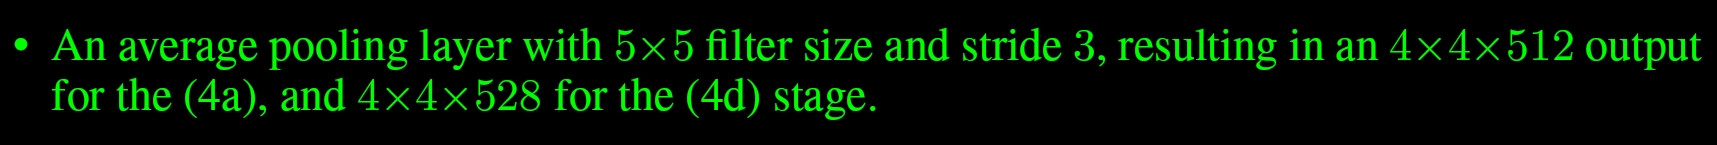

In [10]:
class Auxiliary_Classifier(nn.Module):
    def __init__(self, in_channels, num_class):
        super().__init__()
        self.feature_ = nn.Sequential(nn.AdaptiveAvgPool2d((4, 4)),
                                      BasicConvBlock(in_channels, 128, kernel_size=1, stride=1, padding=0)
                                     )
        self.cla_ = nn.Sequential(nn.Linear(4*4*128, 1024), 
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(0.7),
                                  nn.Linear(1024, num_class), 
                                  nn.Softmax(dim=1)
                                 )
    def forward(self, x):
        x = self.feature_(x)
        x = self.cla_(x.view(-1, 4*4*128))
        return x

## 驗證

In [11]:
aux = Auxiliary_Classifier(528, 1000)

In [12]:
aux(torch.ones([10, 528, 14, 14])).shape

torch.Size([10, 1000])

# GoogleNet

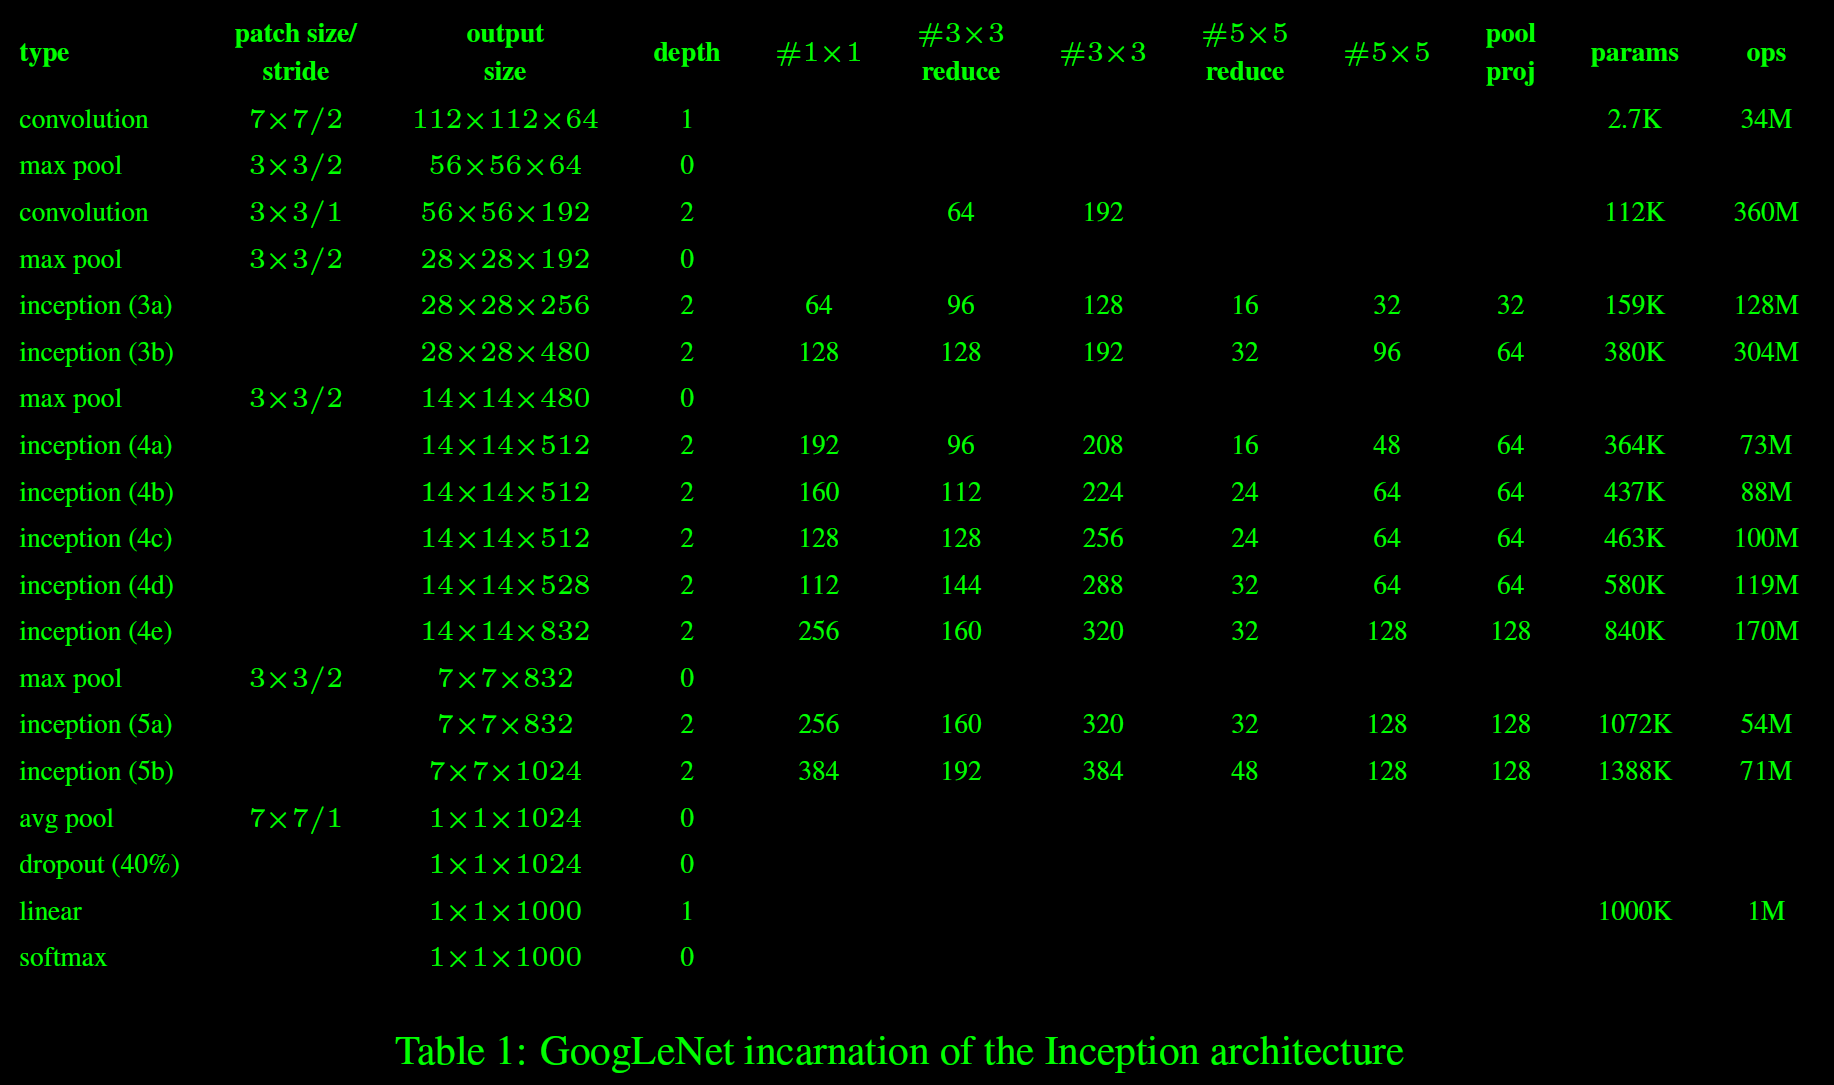

In [13]:
class GoogleNet(nn.Module):
    def __init__(self, num_class):
        super().__init__()  
        # (h + 2p - k)/s + 1
        # (h + 2p - 7)/2 + 1 = h/2 --> 2p - 7 + 2 = 1 --> p=3
        self.block1 = nn.Sequential(BasicConvBlock(3, 64, kernel_size=7, stride=2, padding=3),
                                    # (h + 2p - 3)/2 + 1 = h/2 --> 2p-3+2=1 --> p=1
                                    nn.MaxPool2d(3, stride=2, padding=1),
                                    BasicConvBlock(64, 64, kernel_size=1, stride=1, padding=0),
                                    BasicConvBlock(64, 192, kernel_size=3, stride=1, padding=1),
                                    nn.MaxPool2d(3, stride=2, padding=1)
                                   )
        # Inception 3a + 3b
        self.block2 = nn.Sequential(InceptionBlock(192, 64, 96, 128, 16, 32, 32),
                                    InceptionBlock(256, 128, 128, 192, 32, 96, 64),
                                    nn.MaxPool2d(3, stride=2, padding=1)
                                   )
        # inception_4 a~e, maxpool
        self.inception_4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool_after_4e = nn.MaxPool2d(3, stride=2, padding=1)
        # block4 5a ~ 5b
        self.block4 = nn.Sequential(InceptionBlock(832, 256, 160, 320, 32, 128, 128),
                                    InceptionBlock(832, 384, 192, 384, 48, 128, 128)
                                   )
        # block5  avgpool ~ softmax
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_class)
        self.softmax = nn.Softmax(dim=1)
        
        self.auxiliary_classifier_4a = Auxiliary_Classifier(512, num_class)
        self.auxiliary_classifier_4d = Auxiliary_Classifier(528, num_class)
        
    def forward(self, x):
        # conv 7*7 ~ maxpool
        x = self.block2(self.block1(x))
        
        # block3 4a~ 4e +maxpool
        x_4a = self.inception_4a(x)
        x_4d = self.inception_4d(self.inception_4c(self.inception_4b(x_4a)))
        x = self.maxpool_after_4e(self.inception_4e(x_4d))
        
        # block4  5a ~ 5b
        x = self.block4(x)
        
        # block5  avgpool ~ softmax
        x = x = self.avgpool(x)
        x = self.dropout(x.view(-1, 1024))
        x = self.softmax(self.fc(x))
        # Auxiliary_Classifier_4a
        aux_4a = self.auxiliary_classifier_4a(x_4a)
        
        # Auxiliary_Classifier_4d
        aux_4d = self.auxiliary_classifier_4d(x_4d)
        return x, aux_4a, aux_4d

# 驗證

In [14]:
net = GoogleNet(1000)

In [15]:
x, aux_4a, aux_4d = net(torch.ones([10, 3, 224, 224]))

In [16]:
x.shape
aux_4a.shape
aux_4d.shape

torch.Size([10, 1000])

In [22]:
net = GoogleNet(1000)
summary(net, [10, 3, 224, 224], device="cpu", depth=1)

Layer (type:depth-idx)                             Output Shape              Param #
GoogleNet                                          [10, 1000]                --
├─Sequential: 1-1                                  [10, 192, 28, 28]         124,736
├─Sequential: 1-2                                  [10, 480, 14, 14]         553,440
├─InceptionBlock: 1-3                              [10, 512, 14, 14]         376,800
├─InceptionBlock: 1-4                              [10, 512, 14, 14]         449,808
├─InceptionBlock: 1-5                              [10, 512, 14, 14]         510,768
├─InceptionBlock: 1-6                              [10, 528, 14, 14]         606,080
├─InceptionBlock: 1-7                              [10, 832, 14, 14]         869,376
├─MaxPool2d: 1-8                                   [10, 832, 7, 7]           --
├─Sequential: 1-9                                  [10, 1024, 7, 7]          2,489,824
├─AdaptiveAvgPool2d: 1-10                          [10, 1024, 1, 1]      

In [23]:
net = models.googlenet()
summary(net, [10, 3, 224, 224], device="cpu", depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [10, 1000]                6,379,984
├─BasicConv2d: 1-1                       [10, 64, 112, 112]        9,536
├─MaxPool2d: 1-2                         [10, 64, 56, 56]          --
├─BasicConv2d: 1-3                       [10, 64, 56, 56]          4,224
├─BasicConv2d: 1-4                       [10, 192, 56, 56]         110,976
├─MaxPool2d: 1-5                         [10, 192, 28, 28]         --
├─Inception: 1-6                         [10, 256, 28, 28]         155,872
├─Inception: 1-7                         [10, 480, 28, 28]         340,224
├─MaxPool2d: 1-8                         [10, 480, 14, 14]         --
├─Inception: 1-9                         [10, 512, 14, 14]         364,512
├─Inception: 1-10                        [10, 512, 14, 14]         425,232
├─Inception: 1-11                        [10, 512, 14, 14]         486,192
├─Inception: 1-12                        [